# Project 1: Articles/Posts Topic Classifier

### IMPORTS

In [178]:
import json # for data
import pandas as pd # for data 
import numpy as np # for data

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

import re # preprocessing
import nltk # preprocessing
from nltk.corpus import stopwords # preprocessing
import nltk # preprocessing
import nltk # preprocessing

from sklearn import model_selection # for model

import gensim ## for word embedding
import gensim.downloader as gensimAPI ## for word embedding
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [179]:
dict = []
with open('data.json', mode = 'r', errors = 'ignore') as json_file:
    for dic in json_file:
        dict.append( json.loads(dic) )
## print the first one
dict[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [196]:
## create dtf
dataSet = pd.DataFrame(dict)
## filter categories
dataSet = dataSet[ dataSet["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
## print 5 random rows
dataSet.sample(5)

,category,headline
32706,POLITICS,3 Terrifying Reasons For Trump's Latest Rant
67580,POLITICS,L.A. Prosecutors File Criminal Charges Against...
14003,POLITICS,'Enemy Combatants' Again?
73154,TECH,"Technology Can't Solve Problems By Itself, Say..."
103549,POLITICS,Photo of Barack Obama's Irish Immigrant 3rd Gr...


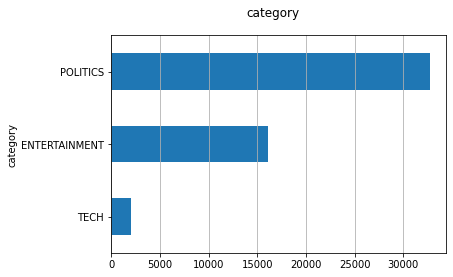

In [197]:
fig, ax = plt.subplots()
fig.suptitle("category", fontsize=12)
dataSet["category"].reset_index().groupby("category").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [198]:
def processText(text):
    ## removing the special characters (\r & \n) and punctuations, convert to lowercase, and strip  
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower().replace('\n',' ').replace('\r','').strip()
            
    ## Tokenize (convert from string to list)
    wordTokens = text.split()
    
    ## remove Stopwords
    stopWords = set(stopwords.words('english')) 
    filteredSentence = [w for w in wordTokens if not w in stopWords] 
    filteredSentence = [] 
    for w in wordTokens: 
        if w not in stopWords: 
            filteredSentence.append(w) 
                
    ## Stemming (remove -ing, -ly, ...)
    ps = nltk.stem.porter.PorterStemmer()
    filteredSentence = [ps.stem(word) for word in filteredSentence]
                
    ## Lemmatisation (convert the word into root word)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    filteredSentence = [lem.lemmatize(word) for word in filteredSentence]
            
    ## back to string from list
    text = " ".join(filteredSentence)
    return text

In [199]:
stopWords = nltk.corpus.stopwords.words("english")

In [203]:
dataSet["headline_clean"] = dataSet["headline"].apply(lambda x: process_text(x))
dataSet.head()

,category,headline,headline_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicki jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marri first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna marguli use donald trump poop bag pic...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devast sexual harass claim coul...


In [204]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dataSet, test_size=0.2)
## get target
y_train = dtf_train["category"].values
y_test = dtf_test["category"].values

In [205]:
corpus = dtf_train["headline_clean"]

# ## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

biGramPhrases = gensim.models.Phrases(lst_corpus, min_count=5, threshold=50)
triGramsPhrases = gensim.models.Phrases(biGramPhrases[lst_corpus], threshold=50)

bigram = gensim.models.phrases.Phraser(biGramPhrases)
trigram = gensim.models.phrases.Phraser(triGramsPhrases)

In [206]:
## fit w2v
# the target size of the word vectors=300
# the window=the mean length of text in the corpus (the maximum distance between the current and predicted word within a sentence)
# sg=1: the algorithm used, skip-grams in this case
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=300, window=8, min_count=1, sg=1, workers=30)

In [152]:
# word = "data"
# nlp[word].shape

In [207]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [208]:
corpus = dtf_test["headline_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigram[lst_corpus])
lst_corpus = list(trigram[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [209]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [210]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, "|vector")

dic[word]: 664 |idx
embeddings[idx]: (300,) |vector


In [211]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 15, 300)      5575500     ['input_5[0][0]']                
                                                                                                  
 permute_4 (Permute)            (None, 300, 15)      0           ['embedding_4[0][0]']            
                                                                                                  
 dense_12 (Dense)               (None, 300, 15)      240         ['permute_4[0][0]']              
                                                                                            

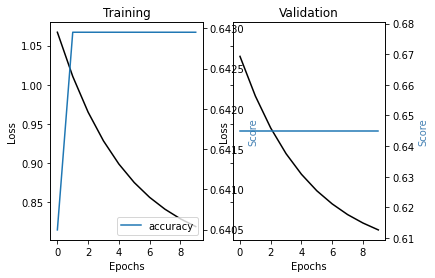

In [212]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [213]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

318/318 [==============================] - 3s 6ms/step
